# Saturne et Venus

- **Binôme**: Inès DUFLOS, Julia JACQUIN
- **Année**: 2021/2022

In [1]:
from PIL import Image, ImageDraw, ImageFont
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import pandas as pd
import seaborn as sns
from glob import glob
import sys
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
from utilities import *

dataset_dir = 'data'
images = load_images(dataset_dir, "*.jpg")

In [2]:
def my_foreground_filter(img):
    foreground = foreground_redness_filter(img, theta=.35)
    foreground = invert_if_light_background(foreground)
    foreground = scipy.ndimage.gaussian_filter(foreground, sigma=.1)
    return foreground

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [4]:
model_name = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
model_list = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

## Jeu de données

In [5]:
dataset_dir = 'data'
images = load_images(dataset_dir, "*.jpg")

##### Saturne :

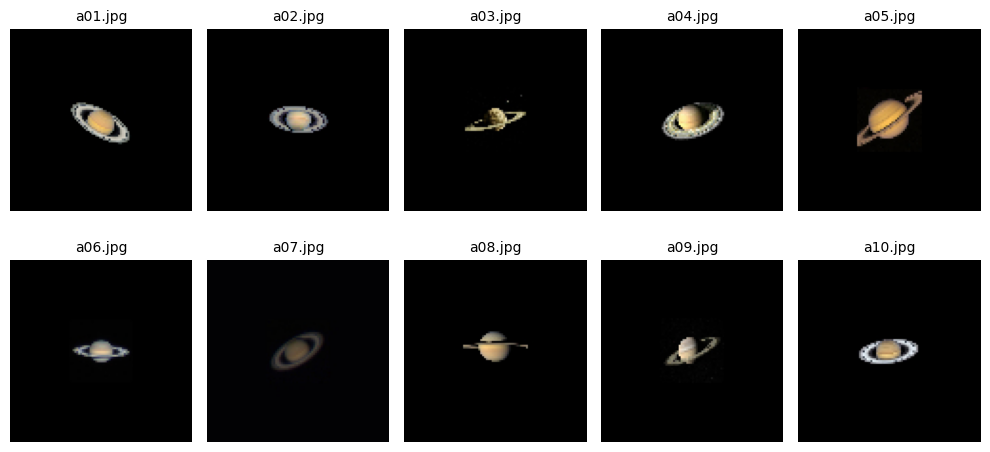

In [6]:
n1 = 10
first = images[:n1]
image_grid(first, titles=first.index)

##### Venus :

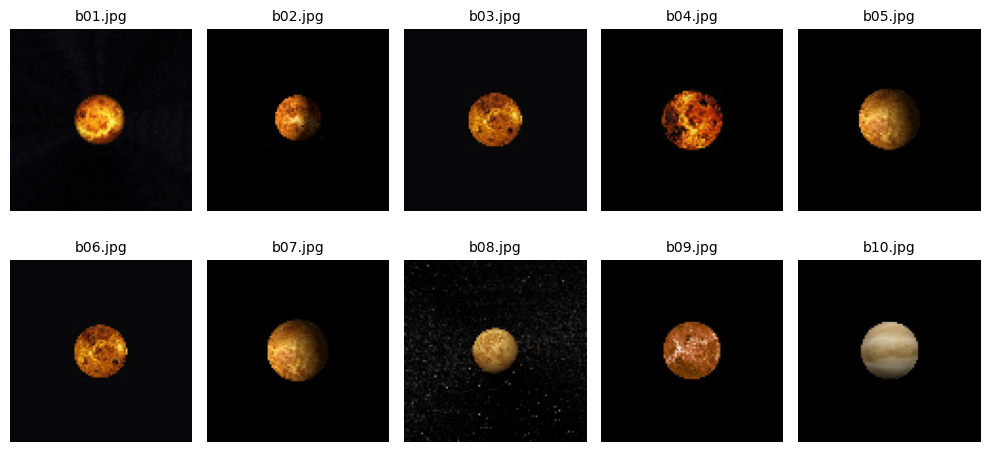

In [7]:
last = images[n1:]
image_grid(last, titles=last.index)

## Prétraitement

### Extraction de l'avant plan de nos images

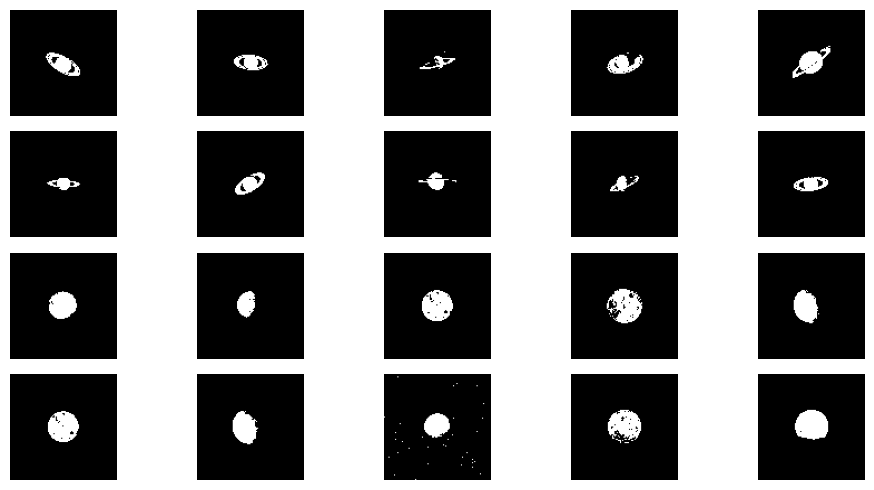

In [8]:
images_AP = [scipy.ndimage.gaussian_filter(invert_if_light_background(
    foreground_redness_filter(img, theta=.35)),sigma=.1)for img in images]
image_grid(images_AP)

### Recadrage des images par rapport au centre des planètes

/var/folders/1b/pzbtl7hn7mdgnqt59jg_tnn40000gn/T/ipykernel_10105/4026779011.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  foreground = my_foreground_filter(images[9])
/var/folders/1b/pzbtl7hn7mdgnqt59jg_tnn40000gn/T/ipykernel_10105/4026779011.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.imshow(crop_around_center(images[9], center))


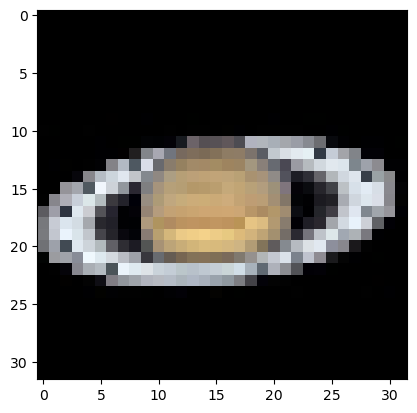

In [9]:
foreground = my_foreground_filter(images[9])
coordinates = np.argwhere(foreground)
center = (np.mean(coordinates[:,1]), np.mean(coordinates[:,0]))
plt.imshow(crop_around_center(images[9], center))

### Création d'images "clean"

In [10]:
def my_preprocessing(img):
    foreground = my_foreground_filter(img)
    img = transparent_background(img, foreground)
    coordinates = np.argwhere(foreground)
    if len(coordinates) == 0: # Cas particulier: il n'y a aucun pixel dans l'avant plan
        width, height = img.size
        center = (width/2, height/2)
    else:
        center = (np.mean(coordinates[:, 1]), np.mean(coordinates[:, 0]))
    img = crop_around_center(img, center)
    return img

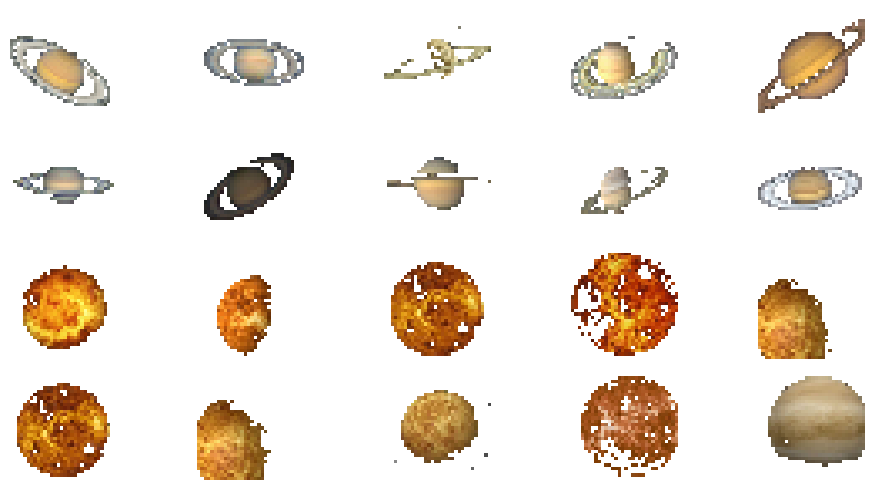

In [11]:
clean_images = images.apply(my_preprocessing)
clean_sample = list(clean_images[:10]) + list(clean_images[-10:])
image_grid(clean_sample)

In [13]:
import pandas as pd
import os

if not os.path.exists('clean_data1.csv'):
    print("\nCréation du fichier clean_data1.csv...")
    
    df_clean = pd.DataFrame({
        'redness': clean_images.apply(redness),
        'blueness': clean_images.apply(blueness),
        'elongation': clean_images.apply(elongation),
        'class': [1 if name.startswith('a') else 0 for name in clean_images.index]
    })
    
    class_counts = df_clean['class'].value_counts()
    if len(class_counts) != 2:
        raise ValueError(f"Problème de classification ! Classes trouvées : {class_counts}")
    
    df_clean.to_csv('clean_data1.csv')
    print("Fichier créé avec succès!")
else:
    df_clean = pd.read_csv('clean_data1.csv', index_col=0)

In [14]:
df_clean = clean_images.apply(image_to_series)
df_clean = pd.read_csv('clean_data1.csv', index_col=0)

### Attributs choisis

In [15]:
df_features = pd.DataFrame({'redness': clean_images.apply(redness),
                            'greenness': clean_images.apply(greenness),
                            'blueness': clean_images.apply(blueness),
                            'elongation': clean_images.apply(elongation),
                            'perimeter': clean_images.apply(perimeter),
                            'surface': clean_images.apply(surface)})
df_features["class"] = df_clean["class"]
corr = df_features.corr()
corr.style.format(precision=2).background_gradient(cmap='coolwarm')

,redness,greenness,blueness,elongation,perimeter,surface,class
redness,1.00,0.88,-0.97,-0.77,0.67,0.69,-0.86
greenness,0.88,1.00,-0.96,-0.72,0.45,0.54,-0.83
blueness,-0.97,-0.96,1.00,0.77,-0.59,-0.64,0.87
elongation,-0.77,-0.72,0.77,1.00,-0.70,-0.78,0.85
perimeter,0.67,0.45,-0.59,-0.70,1.00,0.98,-0.68
surface,0.69,0.54,-0.64,-0.78,0.98,1.00,-0.76
class,-0.86,-0.83,0.87,0.85,-0.68,-0.76,1.00


Les attributs que nous avons choisis sont donc:
- la redness
- la blueness
- l'élongation

In [16]:
df_attributs = pd.DataFrame({'redness': clean_images.apply(redness),
                            'blueness': clean_images.apply(blueness),
                            'elongation': clean_images.apply(elongation)})
df_attributs["class"] = df_clean["class"]

## Visualisation des données

In [17]:
sklearn_model = KNeighborsClassifier(n_neighbors=3)
df_raw = images.apply(image_to_series)
df_raw['class'] = df_raw.index.map(lambda name: 1 if name[0] == 'a' else -1)
p_tr1, s_tr1, p_te1, s_te1 = df_cross_validate(df_raw, sklearn_model, sklearn_metric)
metric_name = sklearn_metric.__name__.upper()
print("AVERAGE TRAINING {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_tr1, s_tr1))
print("AVERAGE TEST {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_te1, s_te1))

AVERAGE TRAINING BALANCED_ACCURACY_SCORE +- STD: 0.97 +- 0.05
AVERAGE TEST BALANCED_ACCURACY_SCORE +- STD: 0.91 +- 0.05


In [18]:
performances= pd.DataFrame(columns = ['Traitement', 'perf_tr', 'std_tr', 'perf_te', 'std_te'])
performances.loc[0] = ["Images brutes", p_tr1, s_tr1, p_te1, s_te1]
performances.style.format(precision=2).background_gradient(cmap='Blues')

,Traitement,perf_tr,std_tr,perf_te,std_te
0,Images brutes,0.97,0.05,0.91,0.05


In [19]:
p_tr2, s_tr2, p_te2, s_te2 = df_cross_validate(df_attributs, sklearn_model, sklearn_metric)
metric_name = sklearn_metric.__name__.upper()
print("AVERAGE TRAINING {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_tr2, s_tr2))
print("AVERAGE TEST {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_te2, s_te2))

AVERAGE TRAINING BALANCED_ACCURACY_SCORE +- STD: 0.96 +- 0.05
AVERAGE TEST BALANCED_ACCURACY_SCORE +- STD: 0.93 +- 0.05


In [20]:
performances.loc[1] = ["Images prétraitées", p_tr2, s_tr2, p_te2, s_te2]
performances.style.format(precision=2).background_gradient(cmap='Blues')

,Traitement,perf_tr,std_tr,perf_te,std_te
0,Images brutes,0.97,0.05,0.91,0.05
1,Images prétraitées,0.96,0.05,0.93,0.05


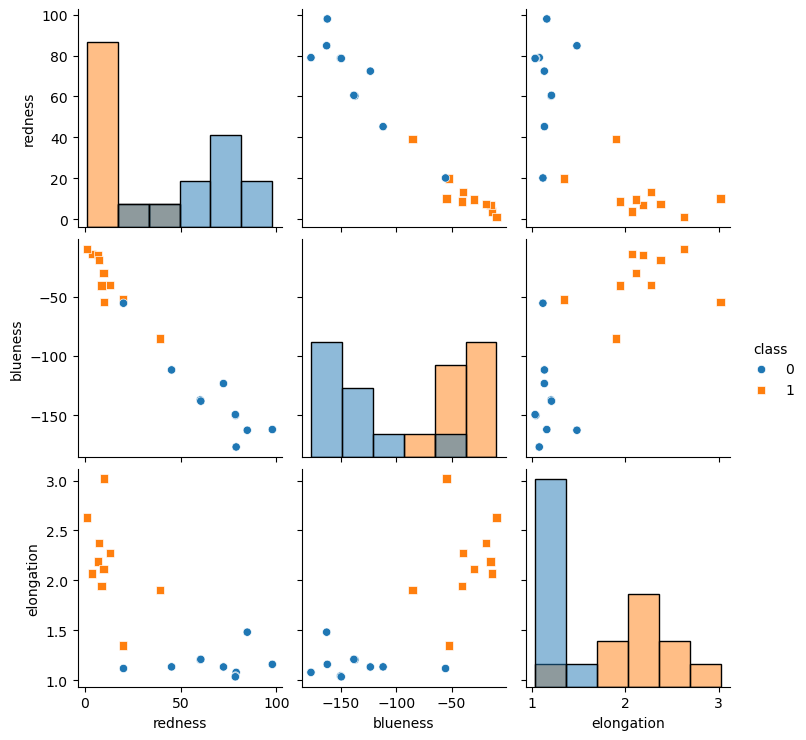

In [21]:
sns.pairplot(df_attributs, hue="class", markers=["o", "s"], diag_kind="hist")

## Classificateurs favoris

In [23]:
compar_results = systematic_model_experiment(df_attributs, model_name, model_list, sklearn_metric)
compar_results.style.format(precision=2).background_gradient(cmap='Blues')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklear

,perf_tr,std_tr,perf_te,std_te
Nearest Neighbors,0.96,0.05,0.93,0.05
Linear SVM,0.97,0.05,0.87,0.08
RBF SVM,1.00,0.00,0.64,0.16
Gaussian Process,1.00,0.00,0.84,0.09
Decision Tree,1.00,0.00,0.88,0.04
Random Forest,1.00,0.00,0.90,0.04
Neural Net,0.75,0.22,0.70,0.21
AdaBoost,1.00,0.00,0.89,0.03
Naive Bayes,1.00,0.00,0.88,0.04
QDA,1.00,0.00,0.80,0.13


Nos classificateurs favoris sont:
- Nearest Neighbors
- Random Forest

Ce sont les classificateurs avec les meilleures performances aux tests et avec des écarts types assez bas pour les tests.

## Résultats

### Observations

Les résultats que nous avons obtenu sont globalement très bon que ça soit en utilisant nos images prétraitées ou non. Dans les deux cas la précision de nos tests est d'environ 90% avec un écart type de 5%.

De plus, dans le pairplot on a pu voir que les deux classes étaient assez bien séparés même si toutes les images n'étaient pas parfaitement séparés.

### Interprétations

Nos attributs peuvent séparer les images de venus et de saturne sans que celles-ci soient prétraitées sans qu'il y ait trop d'erreurs, cela peut s'expliquer par le fait que les planètes sont sur un fond très foncé voir noir où il n'y a aucun autre objet. Il est donc relativement facile d'extraire les planètes et de les différencier. 

De plus, les deux planètes que nous avons choisis ont des formes différentes ce qui nous permet de les différencier sans trop de difficultées.

## Discussion 

Un biais de nos données est que nos images de venus sont pour la plupart similaires, nous avons cependant tenté d'éviter au maximum les biais notamment en prennant des images de saturne avec des orientations différentes et des couleurs un peu différentes.

L'une des principales difficultées que nous avons rencontré a été la conversion de nos images en jpg en images au format png. Pour surmonter cette difficulté nous avons demandé de l'aide au professeur lors du TP.

## Conclusion

Finalement, les résultats que nous avons obtenu sont très satisfaisant pour les images prétraitées mais également pour celles qui ne le sont pas. Il peut y avoir deux raisons qui expliqueraient ces résultats, soit les attributs que nous avons utilisé étaient très performant et parfaitement adapté à nos images, soit nos images ne sont pas trop compliquées (ce parait plus probable).